In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math
from sklearn.metrics import r2_score
from labellines import labelLines


os.environ["QT_QPA_PLATFORM"] = "xcb"
plt.rcParams["axes.unicode_minus"] = False

plt.rcParams["axes.labelsize"] = 18
plt.rcParams["axes.titlesize"] = 18

## Setting constants
g_Na = 120
g_K = 36
g_L = 0.3
e_Na = 115
e_K = -12
e_L = 10.6
# each time bin is 0.001 ms
dt = 0.001
t = 400
# start injecting inputs at t = 50 ms
input_start_time = 50
input_start_bins = int(input_start_time / dt)
times = np.arange(0, t, dt)

In [3]:
w = np.array([1, 2, 3, 4, 5, 6])
w_1, w_2, w_3 = np.array([1, 2]), np.array([3, 4]), np.array([5, 6])
v_1 = np.random.rand(2, 3)
v_2 = np.random.rand(2, 3)
v_3 = np.random.rand(2, 3)
v = np.concatenate([v_1, v_2, v_3], axis=0)

truth = w @ v
test = w_1.T @ v_1 + w_2.T @ v_2 + w_3.T @ v_3
print(truth)
print(test)

[13.21674316  6.35670213 10.26431428]
[13.21674316  6.35670213 10.26431428]


In [2]:
## Coding up the model
def alpha_m(V):
    return (2.5 - 0.1 * V) / (np.exp(2.5 - 0.1 * V) - 1)


def beta_m(V):
    return 4 * np.exp(-V / 18)


def alpha_h(V):
    return 0.07 * np.exp(-V / 20)


def beta_h(V):
    return 1 / (np.exp(3.0 - 0.1 * V) + 1)


def alpha_n(V):
    return (0.1 - 0.01 * V) / (np.exp(1 - 0.1 * V) - 1)


def beta_n(V):
    return 0.125 * np.exp(-V / 80)


def simulate_HH_model(I_ext, v_0, m_0, h_0, n_0):
    """Simulate the HH model.

    :param I_ext: array of external current applied.
    :type I_ext: np array.
    :param v_0: initial value of v.
    :type v_0: float.
    :param m_0: initial value of m.
    :type m_0: float.
    :param h_0: initial value of h.
    :type h_0: float
    :param n_0: initial value of n.
    :type n_0: float
    :return: v_array, m_array, h_array, n_array
    :rtype: np arrays.
    """

    v_array = np.zeros(times.shape)
    v_array[0] = v_0
    m_array = np.zeros(times.shape)
    m_array[0] = m_0
    h_array = np.zeros(times.shape)
    h_array[0] = h_0
    n_array = np.zeros(times.shape)
    n_array[0] = n_0

    # Euler's integration step by step
    for i in range(1, len(times)):
        v_array[i] = (
            -g_Na * (m_array[i - 1] ** 3) * h_array[i - 1] * (v_array[i - 1] - e_Na)
            - g_K * (n_array[i - 1] ** 4) * (v_array[i - 1] - e_K)
            - g_L * (v_array[i - 1] - e_L)
            + I_ext[i - 1]
        ) * dt + v_array[i - 1]
        m_array[i] = (
            (alpha_m(v_array[i - 1]) * (1 - m_array[i - 1]))
            - (beta_m(v_array[i - 1]) * m_array[i - 1])
        ) * dt + m_array[i - 1]
        h_array[i] = (
            (alpha_h(v_array[i - 1]) * (1 - h_array[i - 1]))
            - (beta_h(v_array[i - 1]) * h_array[i - 1])
        ) * dt + h_array[i - 1]
        n_array[i] = (
            (alpha_n(v_array[i - 1]) * (1 - n_array[i - 1]))
            - (beta_n(v_array[i - 1]) * n_array[i - 1])
        ) * dt + n_array[i - 1]

    return v_array, m_array, h_array, n_array

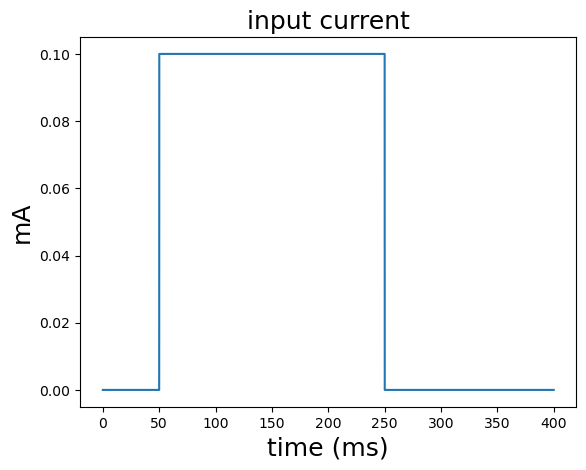

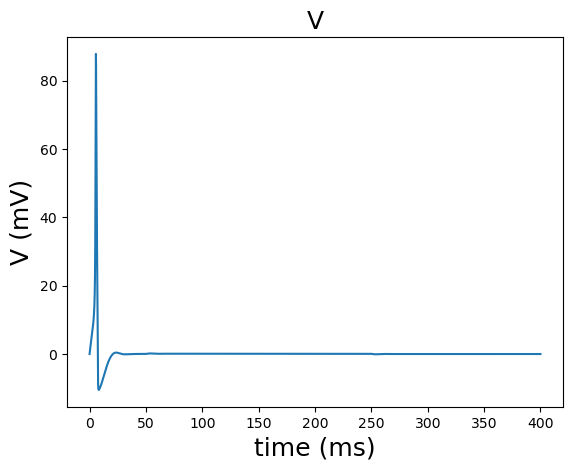

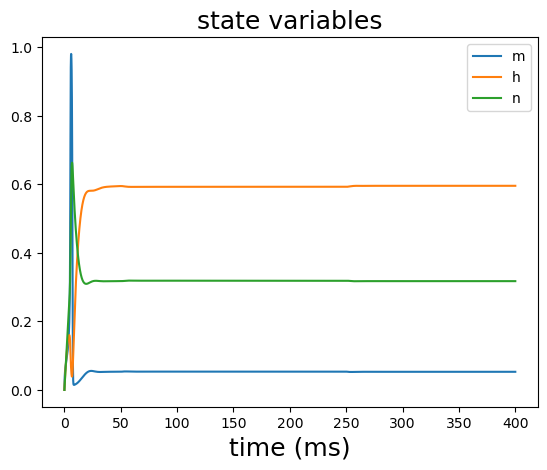

In [3]:
## Question 1: example plots showing V as a function of time
def plot_trajectory(simulation_results, ylabel, title, figname):
    """Plot the resulting tragectories.

    :param simulation_results: simulated location results.
    :type simulation_results: np array.
    :param ylabel: label on vertical axis.
    :type ylabel: string.
    :param title: plot title.
    :type: string.
    """
    plt.plot(times, simulation_results)
    # plt.ylim((-12, -8))
    plt.xlabel("time (ms)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(figname)
    plt.show()


def plot_state_variables(m_array, h_array, n_array):
    """Plot the resulting state variable trajectories.

    :param m_array: simulated m results.
    :type m_array: np array.
    :param h_array: simulated h results.
    :type h_array: np array.
    :param n_array: simulated n results.
    :type n_array: np array.
    """
    plt.plot(times, m_array, label="m")
    plt.plot(times, h_array, label="h")
    plt.plot(times, n_array, label="n")
    plt.legend()
    plt.xlabel("time (ms)")
    plt.title("state variables")
    plt.show()


def generate_I_array(length, I):
    """Generate a long current.

    :param length: length of applide current. 200ms.
    :type length: float.
    :param I: amplitude of applied current.
    :type I: float between 0.1 and 5.
    :return: I array of same length as times.
    :rtype: np array.
    """
    I_array = np.zeros(times.shape)
    num_bins_per_pulse = int(length / dt)
    start_time = input_start_bins
    end_time = start_time + num_bins_per_pulse
    # One long pulse of amplitude I lasting 200 ms
    I_array[start_time:end_time] = I
    # # Delta pulses every 200 ms
    # for i in range(len(times)):
    #     if i % num_bins_per_pulse == 0:
    #         I_array[i] = I
    return I_array


def plot_I_array(I_array):
    """Plot the current generated.

    :param I_array: input current.
    :type I_array: np array.
    """
    plt.plot(times, I_array)
    plt.xlabel("time (ms)")
    plt.ylabel("mA")
    plt.title("input current")
    plt.show()


def calc_v_frequency(v_array, height):
    """Calculate the output action potential frequency.

    :param v_array: action potential array generated.
    :type v_array: np array.
    :param height: height of the peak.
    :type height: float.
    :return: output v frequency.
    :rtype: float
    """
    freq = 0
    if len(v_array) > 1:
        v_array_after_start = v_array[input_start_bins:]
        peaks, _ = scipy.signal.find_peaks(v_array_after_start, height=height)
        avg_period = np.mean(peaks[1:] - peaks[:-1])
        freq = 1 / (avg_period / (1000 / dt))
    return freq


# I_ext range from 0.1 to 5;
I_array = generate_I_array(200, 0.1)
v_array, m_array, h_array, n_array = simulate_HH_model(I_array, 0, 0, 0, 0)
plot_I_array(I_array)
plot_trajectory(v_array, "V (mV)", "V", "1_sample_traj")
plot_state_variables(m_array, h_array, n_array)

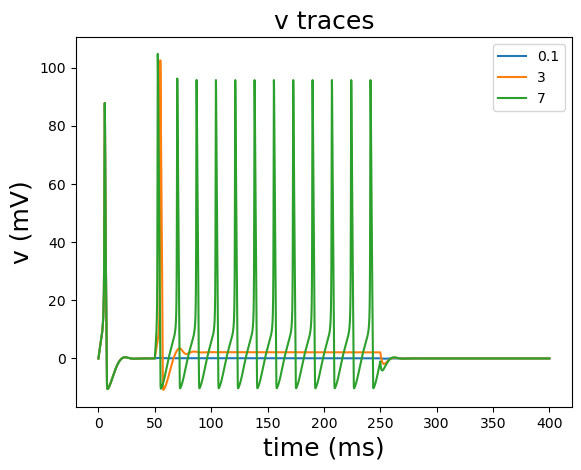

In [4]:
# Plot a few traces on same plot
def plot_two_trajectories(amp_array, title):
    """Plot the resulting tragectories.

    :param amp_array: amplitudes to plot.
    :type amp_array: np array.
    :param title: plot title.
    :type: string.
    """
    for amp in amp_array:
        I_array = generate_I_array(200, amp)
        v_array, m_array, h_array, n_array = simulate_HH_model(I_array, 0, 0, 0, 0)
        plt.plot(times, v_array, label=amp)
    plt.xlabel("time (ms)")
    plt.ylabel("v (mV)")
    plt.legend()
    plt.title(title)
    plt.savefig("1_diff_amp.png")
    plt.show()


amp_array = [0.1, 3, 7]
plot_two_trajectories(amp_array, "v traces")

/home/youjing/anaconda3/envs/courseworks/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/youjing/anaconda3/envs/courseworks/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


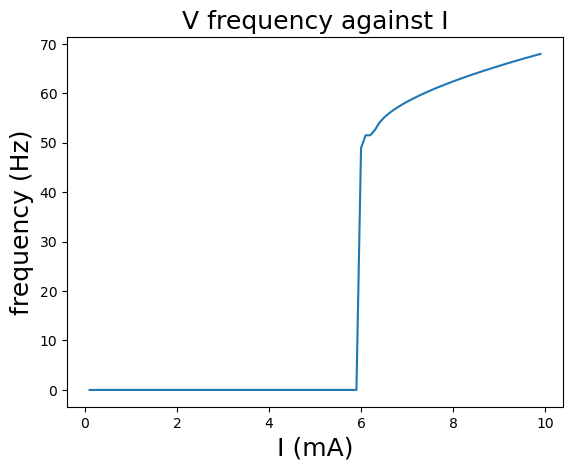

In [5]:
# Plot V frequency as a function of input amplitude
def plot_v_freq_input(height):
    """Plot the response of action potential frequency as a function of input current magnitude.

    :param height: height to determine peaks.
    :type height: float
    """
    input_amplitude_array = np.arange(0.1, 10, 0.1)
    v_frequency_list = []
    for input_amplitude in input_amplitude_array:
        I_array = generate_I_array(200, input_amplitude)
        v_array, m_array, h_array, n_array = simulate_HH_model(I_array, 0, 0, 0, 0)
        v_frequency = calc_v_frequency(v_array, height)
        v_frequency_list.append(v_frequency)

    v_frequency_list = [0 if math.isnan(i) else i for i in v_frequency_list]
    plt.plot(input_amplitude_array, v_frequency_list)
    plt.xlabel("I (mA)")
    plt.ylabel("frequency (Hz)")
    plt.title("V frequency against I")
    plt.savefig("1_freq_amp.png")
    plt.show()


plot_v_freq_input(80)

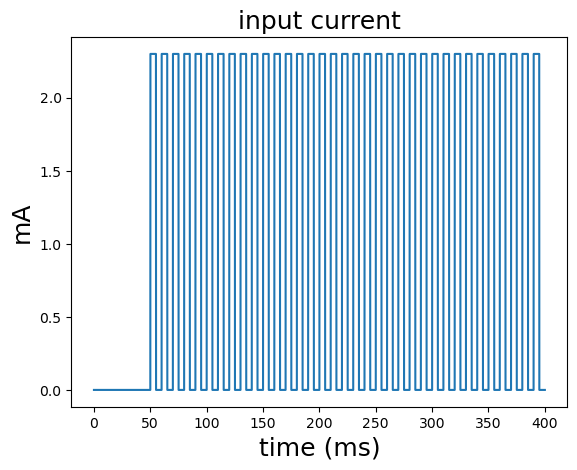

In [6]:
## Q2: generate period square pulse input
def generate_periodic_I_array(T, p, I):
    """Generate the periodic input current array.

    :param T: input current period.
    :type T: float.
    :param p: input current peak period.
    :type p: float.
    :param I: input current magnitude.
    :type I: float.
    :return: input current array.
    :rtype: np array.
    """
    I_array = np.zeros(times.shape)
    num_bins_per_pulse = int(T / dt)
    num_bins_per_input = int(p / dt)
    for i in range(input_start_bins, len(times)):
        if i % num_bins_per_pulse == 0:
            I_array[i : i + num_bins_per_input] = I
    return I_array


# T = 10 - 20, p = 5, I = 2.3
plot_I_array(generate_periodic_I_array(10, 5, 2.3))

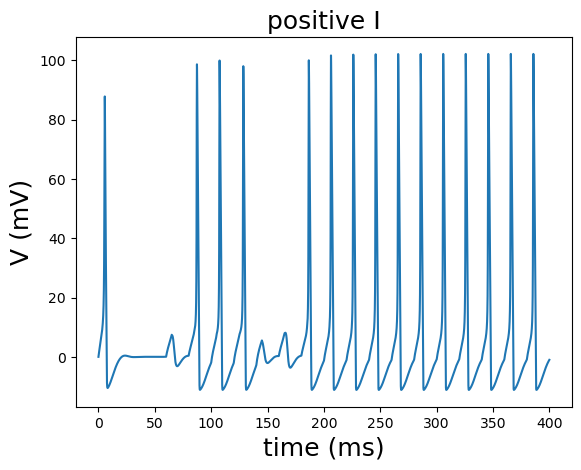

In [7]:
# simulate a few sample traces.
I_array = generate_periodic_I_array(20, 5, 2.3)
v_array, m_array, h_array, n_array = simulate_HH_model(I_array, 0, 0, 0, 0)
plot_trajectory(v_array, "V (mV)", "positive I", "2_sample_v_20.png")

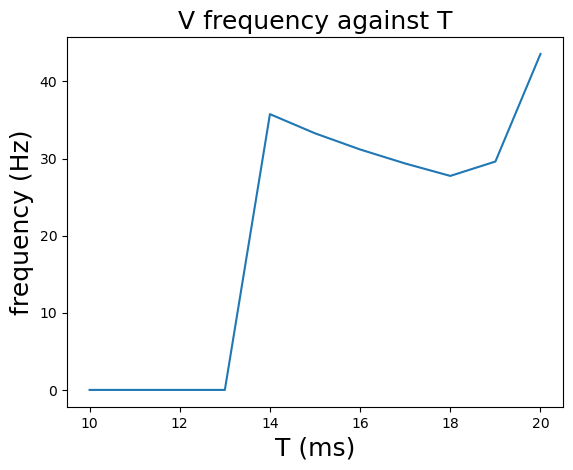

In [8]:
def plot_v_freq_periodic_input(height, I):
    """Plot the output action potential frequency as a function of periodic input.

    :param height: height for determining peaks.
    :type height: float.
    :param I: input current array.
    :type I: np array.
    """
    input_period_array = np.arange(10, 21, 1)
    v_frequency_list = []
    for input_period in input_period_array:
        I_array = generate_periodic_I_array(input_period, 5, I)
        v_array, m_array, h_array, n_array = simulate_HH_model(I_array, 0, 0, 0, 0)
        v_frequency = calc_v_frequency(v_array, height)
        v_frequency_list.append(v_frequency)
    v_frequency_list = [0 if math.isnan(i) else i for i in v_frequency_list]
    plt.plot(input_period_array, v_frequency_list)
    plt.xlabel("T (ms)")
    plt.ylabel("frequency (Hz)")
    plt.title("V frequency against T")
    plt.show()


plot_v_freq_periodic_input(height=80, I=2.3)

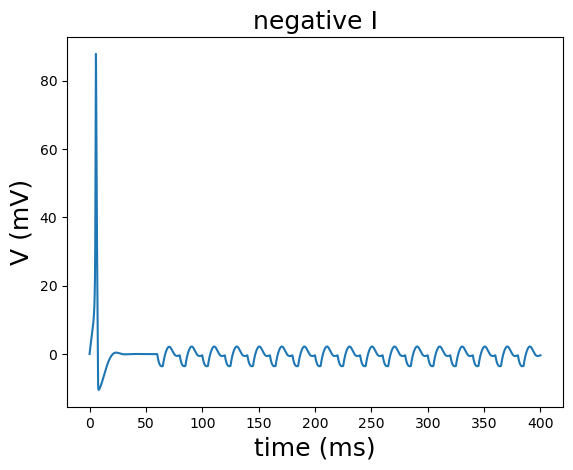

In [9]:
# Negative current
I_array = generate_periodic_I_array(20, 5, -2.3)
v_array, m_array, h_array, n_array = simulate_HH_model(I_array, 0, 0, 0, 0)
plot_trajectory(v_array, "V (mV)", "negative I", "2_sample_v_20_neg")

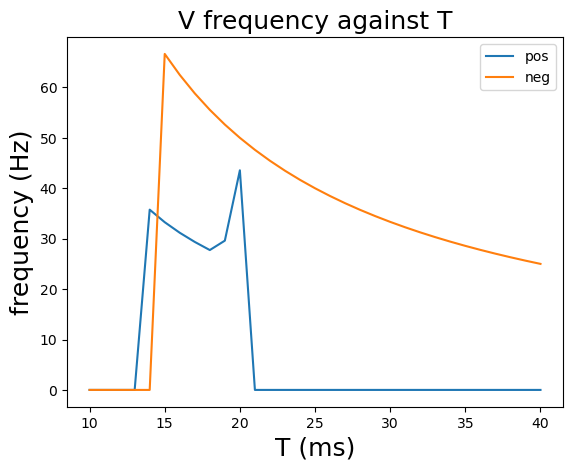

In [10]:
# Plot both positive input current and negative input current on same graph
def plot_v_freq_periodic_input_negative(pos_height, neg_height, I):
    """Plot v frequency against T.

    :param pos_height: height for identifying peak in positive input current.
    :type pos_height: float.
    :param neg_height: height for identifying peak in negative input current.
    :type neg_height: float.
    :param I: magnitude of current. set to 2.3.
    :type I: float.
    """
    input_period_array = np.arange(10, 41, 1)
    v_frequency_pos_list = []
    v_frequency_neg_list = []
    for input_period in input_period_array:
        I_array = generate_periodic_I_array(input_period, 5, I)
        v_array, _, _, _ = simulate_HH_model(I_array, 0, 0, 0, 0)
        v_frequency = calc_v_frequency(v_array, pos_height)
        v_frequency_pos_list.append(v_frequency)

        I_array_neg = I_array * -1
        v_array_neg, _, _, _ = simulate_HH_model(I_array_neg, 0, 0, 0, 0)
        v_frequency_neg = calc_v_frequency(v_array_neg, neg_height)
        v_frequency_neg_list.append(v_frequency_neg)

    v_frequency_pos_list = [0 if math.isnan(i) else i for i in v_frequency_pos_list]
    plt.plot(input_period_array, v_frequency_pos_list, label="pos")
    v_frequency_neg_list = [0 if math.isnan(i) else i for i in v_frequency_neg_list]
    plt.plot(input_period_array, v_frequency_neg_list, label="neg")
    plt.legend()
    plt.xlabel("T (ms)")
    plt.ylabel("frequency (Hz)")
    plt.title("V frequency against T")
    plt.savefig("2_diff_period.png")
    plt.show()


plot_v_freq_periodic_input_negative(pos_height=80, neg_height=2, I=2.3)

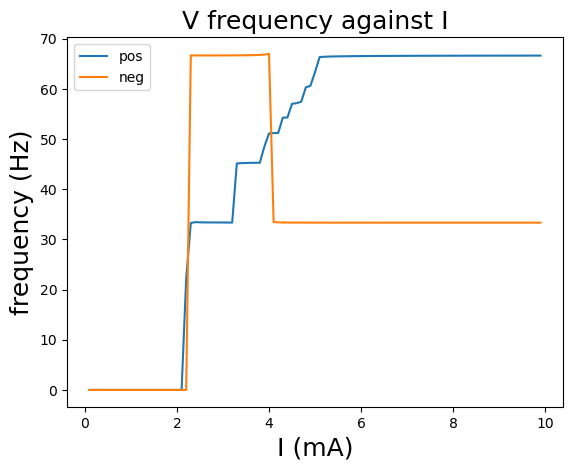

In [11]:
# Plot both positive input current and negative input magnitude on same graph
def plot_v_freq_input_magnitude_negative(pos_height, neg_height, T):
    """Plot v frequency against input current magnitude. Fix T = 15.

    :param pos_height: height for identifying peak in positive input current.
    :type pos_height: float.
    :param neg_height: height for identifying peak in negative input current.
    :type neg_height: float.
    :param I: magnitude of current. set to 2.3.
    :type I: float.
    """
    input_amplitude_array = np.arange(0.1, 10, 0.1)
    v_frequency_pos_list = []
    v_frequency_neg_list = []
    for input_amplitude in input_amplitude_array:
        I_array = generate_periodic_I_array(T, 5, input_amplitude)
        v_array, _, _, _ = simulate_HH_model(I_array, 0, 0, 0, 0)
        v_frequency = calc_v_frequency(v_array, pos_height)
        v_frequency_pos_list.append(v_frequency)

        I_array_neg = I_array * -1
        v_array_neg, _, _, _ = simulate_HH_model(I_array_neg, 0, 0, 0, 0)
        v_frequency_neg = calc_v_frequency(v_array_neg, neg_height)
        v_frequency_neg_list.append(v_frequency_neg)

    v_frequency_pos_list = [0 if math.isnan(i) else i for i in v_frequency_pos_list]
    plt.plot(input_amplitude_array, v_frequency_pos_list, label="pos")
    v_frequency_neg_list = [0 if math.isnan(i) else i for i in v_frequency_neg_list]
    plt.plot(input_amplitude_array, v_frequency_neg_list, label="neg")
    plt.legend()
    plt.xlabel("I (mA)")
    plt.ylabel("frequency (Hz)")
    plt.title("V frequency against I")
    plt.savefig("2_diff_mag.png")
    plt.show()


plot_v_freq_input_magnitude_negative(pos_height=80, neg_height=2, T=15)